# Plotting outputs from Gaussian - Vibrational Spectra

## Description

This Python script processes frequency data from Gaussian output files to create smooth and visually appealing vibrational spectra plots. It works by reading the frequency and intensity data from the files, applying a Gaussian smoothing function, and then plotting the results. The script includes a few key functions: one for setting a shared y-axis label across multiple subplots, and another for extracting and processing the data. Running this script in chunks with Jupyter Notebook is a great way to understand each step and see how the data transforms at each stage. This hands-on approach helps you learn Python and data visualization concepts interactively. 

In [1]:
#Allow Jupyter notebooks to directly display matplotlib images in line:
%matplotlib inline

## Initialization of constants used:

Here we tell the script the resolution that we broaden across (resolution), and the broadening factor (sigma).  The energetic range which we plot in (enMin, enMax).  We also tell the program where to find the data we are using (fileList, given in RELATIVE paths to the data files), and what we want to have them labeled as in the final plot (legends).

In [2]:
resolution = 1
sigma = 14
enMin = 0.
enMax = 3500.

fileList = ["data/ethane.log", \
            "data/benzophenone.log", \
              ]
legends = ["ethane", \
           "benzophenone", \
           ]

## Including Libraries

Instead of a room full of books, we have groupings of code that have already been implemented for us.  Available through installers such as pip or conda, you can take advantage of work that other people have already written to use in your packages.  Called through the 'import' keyword we will tell python to search for and include functions implemented in files external to our current program.  If your python file is getting too long you can even move your own functions to outside files and import them here too:

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import string

Here we edit some defaults from matplotlib so that our font is bolded and 18 pt, and our axis linewidths are 2 pts by default:

In [4]:
font = {'size'  : '18', 'weight'  : 'bold'}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 2

## Functions in Python

Functions in Python are reusable blocks of code that perform a specific task, enabling modular and organized programming. They take input in the form of arguments, process the input, and return an output, making code more efficient and easier to maintain. Additionally, functions enhance code readability and facilitate debugging by isolating different functionalities into self-contained units.

Here we are coding some specific functions. Breifly: 
* `extract` - This function extracts frequency and intensity data from Gaussian output files. It processes either Raman or IR intensity data depending on the typ parameter.  It returns arrays of frequencies and corresponding intensities.
* `gauSmooth` - This function applies gaussian broadening to the frequency and intensity data taken from the extract function and returns a plottable array.

In [5]:
def extract(file, typ='ir'):
    responses = []
    for line in file:
        if "Frequencies" in str(line):
            tmp = str(line).split('\\n')
            tmp = tmp[0].split()
            
            numFreq = len(tmp) - 3
            energy = [float(x) for x in tmp[-numFreq:]]
            intensity = [0. for x in tmp[-numFreq:]]
            
            #Extract intensities of interest, should be w/in 10 lines of Frequencies printing
            for x in range(10):
                line = next(file)
                tmp = str(line).split('\\n')
                tmp = tmp[0].split()
                
                if 'IR Inten' in str(line) and 'ir' == typ:
                    #IR
                    intensity = [float(x) for x in tmp[-numFreq:]]
                    
                if 'Raman Activ' in str(line) and 'raman' == typ:
                    #Raman
                    intensity = [float(x) for x in tmp[-numFreq:]]
                
                if 'Rot. str.' in str(line) and 'vcd' == typ:
                    #VCD
                    intensity = [float(x) for x in tmp[-numFreq:]]
            
            for i in range(len(energy)):
                responses.append([energy[i], intensity[i]])
    
    return np.asarray(responses)

def gauSmooth(sticks, sigma, subPlot):
    for i in range(len(sticks)):
        subPlot[:,1] += (sticks[i,1] / (sigma * np.sqrt(2 * np.pi))) * np.exp(-np.power((sticks[i,0] - subPlot[:,0]),2) / (2 * sigma**2))
    
    return subPlot

## The Main Block 
The main block of the script performs the following tasks:
* Iterates over the fileList, calling the extract and smooth functions for each file, storing the results in plots.
* Sets up subplots for each dataset, normalizes the intensity data, and plots the data.
* Adds a shared y-axis label and customizes tick parameters for better visualization.
* Finally, saves the combined plot as "VibPlts.png".

The program provides a message to track progress through each of the specified files.

In [6]:
###MAIN PROGRAM BEGINS###

plots = []

for fileNM in fileList:
    print("DOING: ", fileNM)
    with open(fileNM) as fileIN:
        sticks = (extract(fileIN, 'ir'))
        if len(sticks) < 1:
            print("WARNING, no frequencies found, please ensure it is a frequency file")
            sticks = (np.asarray([[0., 0.],[0., 0.]]))
        subPlot = np.asarray([[x, 0.] for x in np.arange(enMin, enMax+resolution, resolution)])
        plots.append(gauSmooth(sticks, sigma, subPlot))

plots = np.asarray(plots)

DOING:  data/ethane.log
DOING:  data/benzophenone.log


## Output Plots

Lastly, the program is outputting an image called VibPlts.png which will appear in your current directory when the run completes. You can double-click VibPlts.png to view it in JupyterLab.

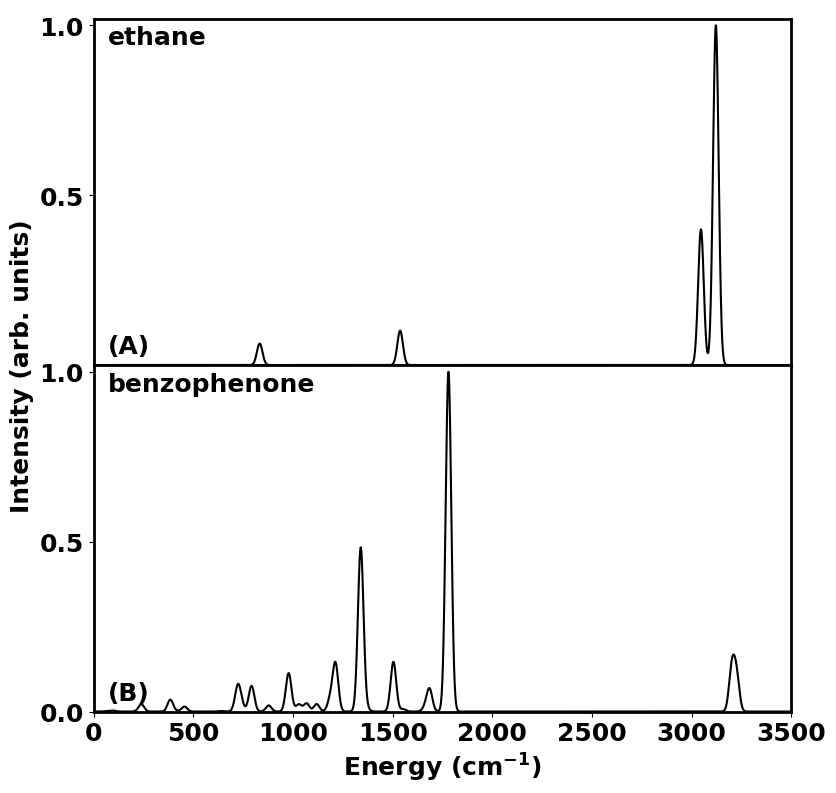

In [7]:
#PLOTTING:
fig, ax = plt.subplots(len(fileList), sharex=True, gridspec_kw={'hspace': 0},figsize=(9,9),squeeze=False)
for i, p in enumerate(plots):
  #Normalize each to itself:
  maxLight = max(p[:,1])
  
  if maxLight > 0:
    p[:,1] = p[:,1] / maxLight
  else:
    print("WARNING, no itns found in energy range, check")
  
  ax[i,0].plot(p[:,0], p[:,1], color='k')
  ax[i,0].set_xlim([0, 3500])
  ax[i,0].text(0.02, 0.02, "(" + string.ascii_uppercase[i] + ")", ha='left',va='bottom', transform=ax[i,0].transAxes)
  ax[i,0].text(0.02, 0.98, legends[i], ha='left',va='top', transform=ax[i,0].transAxes)
  
  if i == len(fileList)-1:
    ax[i,0].set_yticks([0.0,0.5,1.0])
  else:
    ax[i,0].set_yticks([0.5,1])
  ax[i,0].set_ylim([0,1.02])

plt.xlim(enMin, enMax)

#Shared Y-axis label:
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Intensity (arb. units)", fontweight='bold')
plt.xlabel("Energy (cm$^{-1}$)",fontweight='bold')

plt.savefig("VibPlts.png")
plt.show()